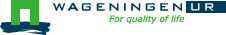



# Building your own model with PCSE

This Jupyter notebook will help you understand the building blocks of PCSE and how to create your own models with it.

Allard de Wit, August 2024

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. PCSE and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The `pandas` module for processing and storing WOFOST output;
  3. The `matplotlib` module for generating charts

**Important notice**

If you start experimenting with this notebook and change the examples you may need to frequently restart the jupyter kernel. Python loads modules only once and therefore changes that you make to the code may not be reflected in the PCSE model results until you restart the kernel which forces python to reload all modules.

# 1. Importing the relevant modules


In [1]:
%matplotlib inline
import sys
from pathlib import Path
import datetime as dt
import yaml
import pandas as pd
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import pcse
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

This notebook was built with:
python version: 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:01:37) [MSC v.1935 64 bit (AMD64)]
PCSE version: 6.0.6


# 2. Developing a basic model

One of the most basic models in agronomy is the Growing Degree Day model. This model simulates plant phenological development by counting the number of degrees above a base temperature. Usually this calculation is based on the daily average temperature, although some models use hourly temperature. 

## The model logic

In the cell below we implement a GrowingDegreeDay model. This model has one state variable (Growing Degree Days: `GDD`), one rate variable (the daily increase in Growing Degree Days `rGDD`) and one parameter (the `BaseTemperature`). See the comments in the code below for more explanation. 

We write this model to a file `gddmodel.py` using the `%%writefile` directive at the top of the cell.

In [2]:
%%writefile gddmodel.py
# Here we import some components from PCSE that are building blocks for
# any model in PCSE.
from pcse.base import SimulationObject, StatesTemplate, RatesTemplate, ParamTemplate
from pcse.traitlets import Float

# Models in PCSE always inherit from SimulationObject
class GrowingDegreeDayModel(SimulationObject):
    """A simple model to accumulate growing degree days between start and end of the crop cycle.
    """

    # This defines the model parameters. It inherits from ParamTemplate, this ensures that parameters
    # receive their value and it signals when parameters are missing.
    class Parameters(ParamTemplate):
        BaseTemperature = Float

    # State variables always inherit from StatesTemplate. StatesTemplate provides certain behaviour
    # such as that state variables must be initialized.
    class StateVariables(StatesTemplate):
        GDD = Float

    # Rate variables are somewhat similar to states but are initialized automatically to zero.
    class RateVariables(RatesTemplate):
        rGDD = Float

    def initialize(self, day, kiosk, parameters):
        """Initialize runs only once, when the model is started. 
        
        It always has three variables:
        - day: the day when the model starts
        - kiosk: the VariableKiosk which is an object which is shared between model components
        - parameters: an object providing the model parameters
        """
        # The code below initializes the parameters, state and rate variables.
        # Note that the initial value of state variable (here: GDD) must be provided.
        self.params = self.Parameters(parameters)
        self.states = self.StateVariables(kiosk, GDD=0.0)
        self.rates = self.RateVariables(kiosk)

    def calc_rates(self, day, drv):
        """calc_rates computes the rate of change that occur during the current day.

        It always has two variables:
        - the current day (a date)
        - the driving variables `drv` that contain the meteorological inputs
        """
        # Here we compute the increase in GDD and assign it to rate variable rGDD
        self.rates.rGDD = max(0.0, drv.TEMP - self.params.BaseTemperature)

    def integrate(self, day, delt):
        """This performs the integration of rates of change onto the states.

        It always has two variables:
        - the current day
        - the time step, which is fixed at 1.0 day
        """
        # Here we add rGDD multiplied by delt to GDD.
        # The multiplication with `delt` is mostly for educational purposes (since delt=1.0) although
        # this may change in the future.
        self.states.GDD += self.rates.rGDD * delt

Overwriting gddmodel.py


Note that the model implementation above does not contain a time loop that steps through the days of the simulation. There is no need to implement this yourself because the PCSE Engine will take care of implementing the time loop and synchronize it with the information on agromanagement.

## A model configuration file

However, the PCSE Engine needs to know about your model. Moreover, it wants a few details such as the variables it needs to collect during the simulation. For this purpose we make an engine configuration file. This configuration file is written in plain python although it usually has the extenstion ".conf" to indicate that it is a configuration file rather than a simulation model.

See below for the configuration file for the GrowingDegreeDay model implemented above. We write it to `gddmodel.conf`.

In [3]:
%%writefile gddmodel.conf

from gddmodel import GrowingDegreeDayModel
from pcse.agromanager import AgroManager

# Module to be used for the soil component (not required yet)
SOIL = None

# Module to be used for the crop simulation itself
CROP = GrowingDegreeDayModel

# Module to use for AgroManagement actions
AGROMANAGEMENT = AgroManager

# variables to save at OUTPUT signals
# Set to an empty list if you do not want any OUTPUT
OUTPUT_VARS = ["GDD", "rGDD"]
# interval for OUTPUT signals, either "daily"|"dekadal"|"monthly"|"weekly"
# For daily output you change the number of days between successive
# outputs using OUTPUT_INTERVAL_DAYS. For dekadal and monthly
# output this is ignored.
OUTPUT_INTERVAL = "daily"
OUTPUT_INTERVAL_DAYS = 1
# Weekday: Monday is 0 and Sunday is 6
OUTPUT_WEEKDAY = 0

# Summary variables to save at CROP_FINISH signals
# Set to an empty list if you do not want any SUMMARY_OUTPUT
SUMMARY_OUTPUT_VARS = ["GDD"]

# Summary variables to save at TERMINATE signals
# Set to an empty list if you do not want any TERMINAL_OUTPUT
TERMINAL_OUTPUT_VARS = []

Overwriting gddmodel.conf


## Defining the model inputs
For actually running the model we require some more components from PCSE. First of all, the `Engine` is required, next we require the `ParameterProvider` which is the component that encapsulates the model parameters and finally we need a component for reading weather data: the `ExcelWeatherDataProvider`

In [4]:
from pcse.engine import Engine
from pcse.base import ParameterProvider
from pcse.input import ExcelWeatherDataProvider

Finally, we need to define some more inputs for running our simulation. 

First of all the parameters that the model requires. In this case the only parameter required is the `BaseTemperature` which is specified through a python dictionary. For the current simulation the `BaseTemperature` is set to 3.0 degrees Celsius. Next, the parameter dictionary is packed through the `ParameterProvider`. For the current simulation this has no advantage but when large sets of parameters are necessary this has clear advantages.

Next, the agromanagement needs to be defined. The simulation starts at 2006-01-01 while emergence takes place at 2006-03-15. We assume the crop gets harvested at 2006-09-25. In this example the `crop_name` and `variety_name` are just labels which have no impact.

Finally, the weather data is imported using the ExcelWeatherDataProvider.

We now have everything to run our model.

In [5]:
cropd = dict(BaseTemperature=3.0)
params = ParameterProvider(cropdata=cropd, sitedata={}, soildata={})

agro  = yaml.safe_load("""
- 2006-01-01:
    CropCalendar:
        crop_name: 'GDDCrop'
        variety_name: 'GDDVariety'
        crop_start_date: 2006-03-15
        crop_start_type: emergence
        crop_end_date: 2006-09-25
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null
""")

weatherfile = Path.cwd() / "data" / "meteo" / "nl1.xlsx"
wdp = ExcelWeatherDataProvider(weatherfile)

## Running the actual model
The code below runs the GrowingDegreeDay model by starting the engine and providing it with the parameters, weather data, agromanagement and the path to the configuration file. 

In [6]:
gdd_config = Path.cwd() / "gddmodel.conf"
gddmodel = Engine(params, wdp, agro, config=gdd_config)
gddmodel.run_till_terminate()

We can now retrieve the model output, convert it to a pandas dataframe and show its content. Als you see, the dataframe contains the columns 'GDD' and 'rGDD' which are the variables specified in the OUTPUT in the configuration file.

In [7]:
df1 = pd.DataFrame(gddmodel.get_output()).set_index("day")
df1.tail()

,GDD,rGDD
day,,
2006-09-21,2253.60,18.65
2006-09-22,2272.25,16.25
2006-09-23,2288.50,17.25
2006-09-24,2305.75,15.60
2006-09-25,2321.35,13.20


Summary output is also available:

In [8]:
print(gddmodel.get_summary_output())

[{'GDD': 2321.3500000000004}]


And finally we can plot the results for the GDD variable as shown below.

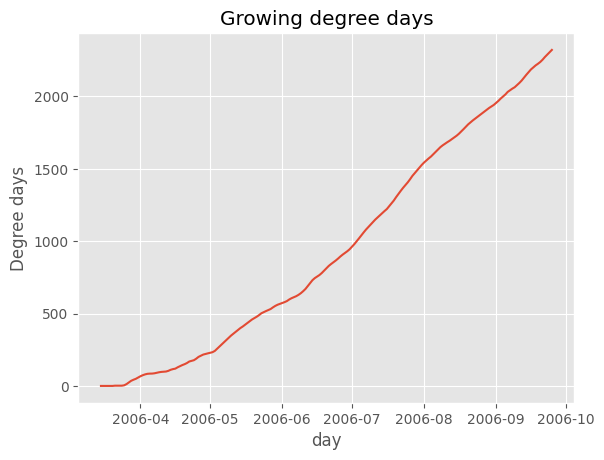

In [9]:
ax = df1.GDD.plot(title="Growing degree days", ylabel="Degree days")

As you can see the total number of growing degree days at harvest is 2321. During the first 1.5 months the GDD values accumulate relatively slowly due to low temperatures, but then the accumulation accellerates in late spring and summer until reaching the harvest date at 2006-09-25.

# 3. Signaling maturity for a given GDD

The model above is useful for computing GDD values between a given emergence and harvest date. However, in many cases we want to apply the model in a prognostic way. E.g. we know the number of degree days a particular crop variety requires to reach maturity and we want to predict the maturity day of that variety in a given environment. To achieve this we need to add a few more details to a our model. 

First, we need to add a new crop parameter that defines the number of degree days to reach maturity, we call his `GDDatMaturity`. Next, it is convenient to save the day when maturity is reached, so an additional state variable `DayOfMaturity` is introduced. Finally, we can instruct the Simulation Engine that the simulation can be stopped because maturity is reached. This is done by sending a `CROP_FINISH` signal through the `_send_signal()` function. The latter is defined within the SimulationObject definition and because our model inherites from SimulationObject we can use it straight away.



In [10]:
%%writefile gddmodel_v2.py
import datetime as dt
from pcse.base import SimulationObject, StatesTemplate, RatesTemplate, ParamTemplate
from pcse.traitlets import Float, Instance
from pcse import signals

class GrowingDegreeDayModelV2(SimulationObject):
    """A simple model to accumulate growing degree days up till GDDatMaturity. The model
    stores the maturity date and triggers a crop_finish signal when maturity is reached.    
    """

    class Parameters(ParamTemplate):
        BaseTemperature = Float
        GDDatMaturity = Float

    class StateVariables(StatesTemplate):
        GDD = Float
        DayofMaturity = Instance(dt.date)

    class RateVariables(RatesTemplate):
        rGDD = Float

    def initialize(self, day, kiosk, parameters):
        self.params = self.Parameters(parameters)
        self.states = self.StateVariables(kiosk, GDD=0.0, DayofMaturity=None)
        self.rates = self.RateVariables(kiosk)

    def calc_rates(self, day, drv):
        self.rates.rGDD = max(0, drv.TEMP - self.params.BaseTemperature)

    def integrate(self, day, delt):
        self.states.GDD += self.rates.rGDD * delt
        if self.states.GDD >= self.params.GDDatMaturity:
            self.states.DayofMaturity = day
            self._send_signal(day=day, signal=signals.crop_finish, crop_delete=True)


Overwriting gddmodel_v2.py


Off course we need to create a configuration file for our new model. The only changes are that we are now importing from the python module that contains the V2 version of our model and we add the DayofMaturity to the SUMMARY_OUTPUT_VARS.

In [11]:
%%writefile gddmodel_v2.conf

from gddmodel_v2 import GrowingDegreeDayModelV2
from pcse.agromanager import AgroManager

# Module to be used for water balance
SOIL = None

# Module to be used for the crop simulation itself
CROP = GrowingDegreeDayModelV2

# Module to use for AgroManagement actions
AGROMANAGEMENT = AgroManager

# variables to save at OUTPUT signals
# Set to an empty list if you do not want any OUTPUT
OUTPUT_VARS = ["GDD", "rGDD"]
# interval for OUTPUT signals, either "daily"|"dekadal"|"monthly"|"weekly"
# For daily output you change the number of days between successive
# outputs using OUTPUT_INTERVAL_DAYS. For dekadal and monthly
# output this is ignored.
OUTPUT_INTERVAL = "daily"
OUTPUT_INTERVAL_DAYS = 1
# Weekday: Monday is 0 and Sunday is 6
OUTPUT_WEEKDAY = 0

# Summary variables to save at CROP_FINISH signals
# Set to an empty list if you do not want any SUMMARY_OUTPUT
SUMMARY_OUTPUT_VARS = ["GDD", "DayofMaturity"]

# Summary variables to save at TERMINATE signals
# Set to an empty list if you do not want any TERMINAL_OUTPUT
TERMINAL_OUTPUT_VARS = []

Overwriting gddmodel_v2.conf


Next, we need to define the parameters and agromanagement for our V2 model. We have one new parameter `GDDatMaturity` which we set at 1500 degree days between emergence and maturity. Moreover, the agromanagement requires an update because we assume to the model to run to maturity instead of harvest. This implies that the crop_end_date is undefined (*null*) and the crop_end_type is *maturity*.

In [12]:
cropd = dict(BaseTemperature=3.0, GDDatMaturity=1500.)
params = ParameterProvider(cropdata=cropd, sitedata={}, soildata={})
agro  = yaml.safe_load("""
- 2006-01-01:
    CropCalendar:
        crop_name: 'GDDCrop'
        variety_name: 'GDDVariety'
        crop_start_date: 2006-03-15
        crop_start_type: emergence
        crop_end_date: null
        crop_end_type: maturity
        max_duration: 300
    TimedEvents: null
    StateEvents: null
""")


Now we can run the V2 model by pointing the engine to the V2 configuration file and running it.

In [13]:
gdd_config = Path.cwd() / "gddmodel_v2.conf"
gddmodelv2 = Engine(params, wdp, agro, config=gdd_config)
gddmodelv2.run_till_terminate()

Next, we can retrieve the output and convert it to a pandas dataframe. When we print the last 5 rows, it is evident that the simulation stopped on 2006-07-30 because the simulation reached 1507 degree days and thus the crop reached maturity which was set at 1500 degrees. 

In [14]:
df2 = pd.DataFrame(gddmodelv2.get_output()).set_index("day")
df2.tail()

,GDD,rGDD
day,,
2006-07-26,1428.00,23.10
2006-07-27,1451.10,19.05
2006-07-28,1470.15,19.50
2006-07-29,1489.65,18.05
2006-07-30,1507.70,18.90


When we plot the GDD we get the same picture as the previous one, except that the simulation is stopped when 1500 degree days were reached.

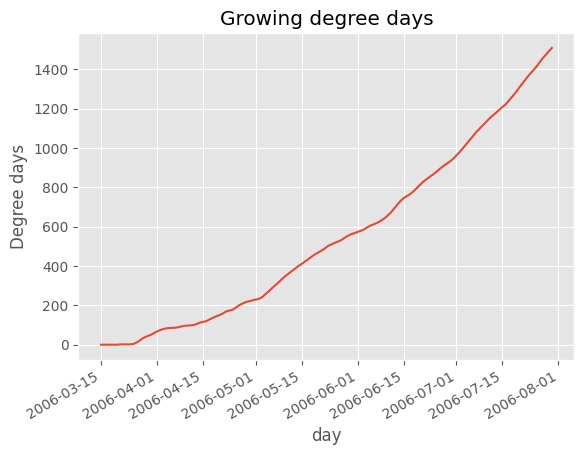

In [15]:
ax = df2.GDD.plot(ylabel="Degree days", title="Growing degree days")
fig = plt.gcf()
fig.autofmt_xdate()

# 4. Interaction between model components

A single model on its own can be useful but often we are interested in the interaction between different components of the system. For crops this often involves the interaction between the soil and the crop but it could also be the development of pest & disease which is influenced by crop development stage for example.

## Accelerated phenological development under water stress
For demonstrating the interaction between a crop and a soil, we will take the case that some crops accelerate their phenological development under water stress. In order to model this we need two new components:
1. a model that prescribes the water stress that the crop is experiencing. In fact a model for simulating the water availability in the soil.
2. a description of the impact of water stress on the rate of phenological development.

For the former, we will use an extremely simple soil water model which models the soil moisture as piecewise linear function which keeps the soil wet until the first of April, then gradually dries out the soil up till a given depletion value is reached at 15 august. From that point we assume that soil moisture linearly increases again until it is fully wet again on 1 November.

For the latter, we will use a linear function that describes the relative increase in development rate as a function of the water stress factor.

### The soil water model

The soil water model is decribed by a few parameters:
- the field capacity  which defines the relative soil moisture content when the soil is wet.
- the wilting point which defines the relative soil moisture content at which plants cannot draw water from the soil anymore.
- a depletion factor which defines how much we let the soil dry out, defined as a fraction (0-1) between field capacity and wilting point.

Moreover, we will assume that plants start to experience water stress when the soil water content is half way between field capacity and wilting point (the critical level) and this water stress is increasing linearly between this critical level and the wilting point. The water stress is expressed in a `WaterStressFactor` that has value 0 when no stress occurs and linearly increases to 1 when the wilting point is reached.

Note that this soil water model does not define any dynamics that are happening in practice (soil water flow, water extraction by roots, infiltration, capillary rise, etc.) but it does serve the purpose of demonstrating interaction between model components in a PCSE model.

The figure below shows the prescribed soil water levels. 

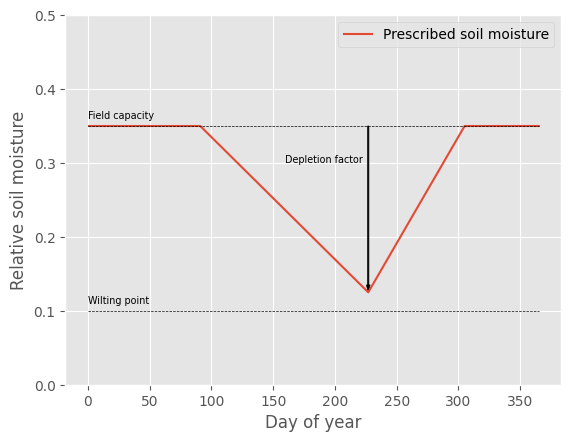

In [16]:
from pcse.util import doy
FieldCapacity = 0.35
WiltingPoint = 0.1
DepletionFactor = 0.9
SM_depleted = FieldCapacity - (FieldCapacity-WiltingPoint) * DepletionFactor
# The seasonal soil moisture is provided in a tabular format
seasonal_soil_moisture = \
    [doy(dt.date(2006,1,1)), FieldCapacity,
     doy(dt.date(2006,4,1)), FieldCapacity,
     doy(dt.date(2006,8,15)), SM_depleted,
     doy(dt.date(2006,11,1)), FieldCapacity,
     doy(dt.date(2006,12,31)), FieldCapacity,
    ]
fig, ax = plt.subplots()
ax.plot(seasonal_soil_moisture[::2], seasonal_soil_moisture[1::2], label="Prescribed soil moisture")
ax.set_ylim(0, 0.5)
ax.set_xlabel("Day of year")
ax.set_ylabel("Relative soil moisture")
ax.plot([0,365], [FieldCapacity, FieldCapacity], linestyle="--", color="black", linewidth=0.5)
ax.text(0, 0.36, "Field capacity", fontsize="x-small")
ax.plot([0,365], [WiltingPoint, WiltingPoint], linestyle="--", color="black", linewidth=0.5)
ax.text(0, 0.11, "Wilting point", fontsize="x-small")
plt.arrow(doy(dt.date(2006,8,15)), FieldCapacity, 0, -1 * (FieldCapacity - SM_depleted), width=1, head_length=0.01, color="black", length_includes_head=True)
ax.text(160, 0.30, "Depletion factor", fontsize="x-small")
r = ax.legend()

### The GDD model with water stress impact

The modified GDD model now includes one additional parameter `MaxRelativeGDDincrease` which specifies the relative increase in the rate of GDD under full water stress (with soil moisture at wilting point). This parameter is multiplied with the WaterStressFactor supplied by the soil water model to simulate the increase in GDD rates.

Below is the implementation of the soil water model and the modified GDD model with accelerated phenology under water stress. An important detail here is the that the WaterStressFactor in the soil water model is a published variable which allows the GrowingDegreeDay model to pick it up from the [VariableKiosk](https://pcse.readthedocs.io/en/stable/reference_guide.html#the-variablekiosk).

In [17]:
%%writefile gddmodel_v3.py
import datetime as dt
from pcse.base import SimulationObject, StatesTemplate, RatesTemplate, ParamTemplate
from pcse.util import doy, limit, AfgenTrait
from pcse.traitlets import Float, Instance
from pcse import signals

class GrowingDegreeDayModelV3(SimulationObject):
    """A simple model to accumulate growing degree days up till GDDatMaturity. The model
    stores the maturity date and triggers a crop_finish signal when maturity is reached.

    The rate of change (rGDD) is modified by a factor that increases rGDD under water stress.
    """

    class Parameters(ParamTemplate):
        BaseTemperature = Float
        GDDatMaturity = Float
        MaxRelativeGDDincrease = Float        

    class StateVariables(StatesTemplate):
        GDD = Float
        DayofMaturity = Instance(dt.date)

    class RateVariables(RatesTemplate):
        rGDD = Float

    def initialize(self, day, kiosk, parameters):
        self.params = self.Parameters(parameters)
        self.states = self.StateVariables(kiosk, GDD=0.0, DayofMaturity=None)
        self.rates = self.RateVariables(kiosk)

    def calc_rates(self, day, drv):
        # compute the increased rate of GDD. Note that the WaterStressFactor is provided
        # by the soil module and can be accessed through self.kiosk
        relGDDinc = 1.0 + self.params.MaxRelativeGDDincrease * self.kiosk.WaterStressFactor
        self.rates.rGDD = max(0, drv.TEMP - self.params.BaseTemperature) * relGDDinc

    def integrate(self, day, delt):
        self.states.GDD += self.rates.rGDD * delt
        if self.states.GDD >= self.params.GDDatMaturity:
            self.states.DayofMaturity = day
            self._send_signal(day=day, signal=signals.crop_finish, crop_delete=True)


class BasicSoilWaterModel(SimulationObject):

    class Parameters(ParamTemplate):
        FieldCapacity = Float
        WiltingPoint = Float
        SeasonalSoilMoisture = AfgenTrait  # Afgen is a linear interpolator object

    class StateVariables(StatesTemplate):
        SoilMoisture = Float
        WaterStressFactor = Float

    def initialize(self, day, kiosk, parameters):
        self.params = self.Parameters(parameters)
        # compute the critical level which is half-way between Field Capacity and Wilting Point
        self._critical_level = (self.params.FieldCapacity + self.params.WiltingPoint)/2.0
    
        SM = self.params.SeasonalSoilMoisture(doy(day))
        self.states = self.StateVariables(kiosk, SoilMoisture=SM, WaterStressFactor=0.0, publish=["WaterStressFactor"])

    def calc_rates(self, day, drv):
        # This model has no dynamics so no rates of change need to be computed
        pass

    def integrate(self, day, delt):
        # Retrieve the soil moisture by linear interpolation based on the day-of-year, Afgen takes care of that.
        self.states.SoilMoisture = self.params.SeasonalSoilMoisture(doy(day))
        # Compute water stress factor and limit it between 0 and 1.
        WSF = (self._critical_level - self.states.SoilMoisture)/(self._critical_level - self.params.WiltingPoint)
        self.states.WaterStressFactor = limit(0.0, 1.0, WSF)
        


Overwriting gddmodel_v3.py


### A configuration for crop and soil components
The new configuration file imports both the GDD model and the soil water model and assigns them to the CROP and SOIL variables. Moreover, two additional outputs are included in the list of OUTPUT_VARS.

In [18]:
%%writefile gddmodel_v3.conf

from gddmodel_v3 import GrowingDegreeDayModelV3, BasicSoilWaterModel
from pcse.agromanager import AgroManager

# Module to be used for water balance
SOIL = BasicSoilWaterModel

# Module to be used for the crop simulation itself
CROP = GrowingDegreeDayModelV3

# Module to use for AgroManagement actions
AGROMANAGEMENT = AgroManager

# variables to save at OUTPUT signals
# Set to an empty list if you do not want any OUTPUT
OUTPUT_VARS = ["GDD", "rGDD", "SoilMoisture", "WaterStressFactor"]
# interval for OUTPUT signals, either "daily"|"dekadal"|"monthly"|"weekly"
# For daily output you change the number of days between successive
# outputs using OUTPUT_INTERVAL_DAYS. For dekadal and monthly
# output this is ignored.
OUTPUT_INTERVAL = "daily"
OUTPUT_INTERVAL_DAYS = 1
# Weekday: Monday is 0 and Sunday is 6
OUTPUT_WEEKDAY = 0

# Summary variables to save at CROP_FINISH signals
# Set to an empty list if you do not want any SUMMARY_OUTPUT
SUMMARY_OUTPUT_VARS = ["GDD", "DayofMaturity"]

# Summary variables to save at TERMINATE signals
# Set to an empty list if you do not want any TERMINAL_OUTPUT
TERMINAL_OUTPUT_VARS = []

Overwriting gddmodel_v3.conf


### Model inputs
The new model requires additional input parameters. So instead of passing only crop parameters, we also need to pass the parameters for the soil model as well.

Note that I also updated the agromanagement definition: I added a ["trailing empty campaign"](https://pcse.readthedocs.io/en/stable/reference_guide.html#finding-the-start-and-end-date-of-a-simulation) to force the system to run to 31 December 2006. This ensure that we can plot the full year and see the soil water availability and water stress factor for the entire year.

In [19]:
cropd = dict(BaseTemperature=3.0, GDDatMaturity=1500., MaxRelativeGDDincrease=0.5)
soild = dict(FieldCapacity=FieldCapacity, WiltingPoint=WiltingPoint, SeasonalSoilMoisture=seasonal_soil_moisture)
params = ParameterProvider(cropdata=cropd, sitedata={}, soildata=soild)
agro  = yaml.safe_load("""
- 2006-01-01:
    CropCalendar:
        crop_name: 'GDDCrop'
        variety_name: 'GDDVariety'
        crop_start_date: 2006-03-15
        crop_start_type: emergence
        crop_end_date: null
        crop_end_type: maturity
        max_duration: 300
    TimedEvents: null
    StateEvents: null
- 2006-12-31:
""")

Now let's run the the model with the interaction between soil and GDD model.

In [20]:
gdd_config = Path.cwd() / "gddmodel_v3.conf"
gddmodelv3 = Engine(params, wdp, agro, config=gdd_config)
gddmodelv3.run_till_terminate()

In [21]:
df3 = pd.DataFrame(gddmodelv3.get_output()).set_index("day")
print(gddmodelv3.get_summary_output())

[{'GDD': 1523.618529411765, 'DayofMaturity': datetime.date(2006, 7, 26)}]


As you can see from the summary output in the results above, the model now reaches maturity at 2006-07-26, 4 days earlier than the model without the impact of water stress. This is also evident from the figure below showing the difference in GDD accumulation, the soil moisture levels and the water stress factor.

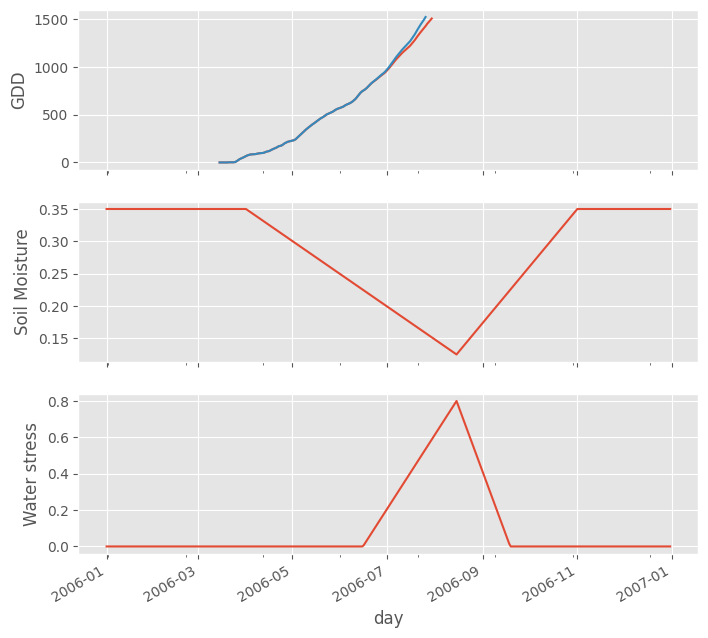

In [22]:
fig, axes = plt.subplots(nrows=3, figsize=(8,8), sharex=True)
df2.GDD.plot(ax=axes[0], label="No water stress")
df3.GDD.plot(ax=axes[0], label="With water stress")
df3.SoilMoisture.plot(ax=axes[1])
df3.WaterStressFactor.plot(ax=axes[2])
axes[0].set_ylabel("GDD")
axes[1].set_ylabel("Soil Moisture")
axes[2].set_ylabel("Water stress")
fig.autofmt_xdate()